# 손동작 분류 경진대회

**https://dacon.io/competitions/official/235876/codeshare/4673?page=1&dtype=recent 를 카피**

In [1]:
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
%matplotlib inline

In [2]:
tf.random.set_seed(42)

In [3]:
train_data = pd.read_csv("C:/Users/choij/Desktop/datasets/hand_gesture_data/train.csv")
test_data = pd.read_csv("C:/Users/choij/Desktop/datasets/hand_gesture_data/test.csv")

print(train_data.shape)
print(test_data.shape) # train 데이터보다 test 데이터가 더 많음을 알 수 있다.
print(train_data.head()) # 34개의 feature 가지고 있음을 알 수 있음

(2335, 34)
(9343, 33)
   id   sensor_1  sensor_2   sensor_3   sensor_4   sensor_5   sensor_6  \
0   1  -6.149463 -0.929714   9.058368  -7.017854  -2.958471   0.179233   
1   2  -2.238836 -1.003511   5.098079 -10.880357  -0.804562  -2.992123   
2   3  19.087934 -2.092514   0.946750 -21.831788   9.119235  17.853587   
3   4  -2.211629 -1.930904  21.888406  -3.067560  -0.240634   2.985056   
4   5   3.953852  2.964892 -36.044802   0.899838  26.930210  11.004409   

    sensor_7   sensor_8   sensor_9  ...  sensor_24  sensor_25  sensor_26  \
0  -0.956591  -0.972401   5.956213  ...  -7.026436  -6.006282  -6.005836   
1  26.972724  -8.900861  -5.968298  ...  -1.996714  -7.933806  -3.136773   
2 -21.069954 -15.933212  -9.016039  ...  -6.889685  54.052330  -6.109238   
3 -29.073369   0.200774  -1.043742  ...  -2.126170  -1.035526   2.178769   
4 -21.962423 -11.950189 -20.933785  ...  -2.051761  10.917567   1.905335   

   sensor_27  sensor_28  sensor_29  sensor_30  sensor_31  sensor_32  target 

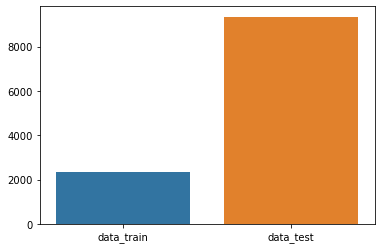

In [4]:
x = ['data_train', 'data_test']
y = [train_data.shape[0], test_data.shape[0]]
plot = sns.barplot(x=x,y=y)

In [5]:
print(train_data.min())
print(train_data.max()) #범위가 -127 ~ 127 이름을 알 수 있음.

id             1.000000
sensor_1     -94.746969
sensor_2     -63.942094
sensor_3    -122.195138
sensor_4    -111.870691
sensor_5     -94.147972
sensor_6     -70.916786
sensor_7    -105.956553
sensor_8    -102.965354
sensor_9     -81.268085
sensor_10    -47.937561
sensor_11   -115.943693
sensor_12   -102.916207
sensor_13   -115.053373
sensor_14    -59.689434
sensor_15   -107.985386
sensor_16   -126.950747
sensor_17    -95.956853
sensor_18    -83.854213
sensor_19   -108.964270
sensor_20   -108.094304
sensor_21   -103.876936
sensor_22    -59.993001
sensor_23    -93.171275
sensor_24   -127.797649
sensor_25    -99.115177
sensor_26    -86.193378
sensor_27   -105.751637
sensor_28   -105.890010
sensor_29    -74.977182
sensor_30    -74.006065
sensor_31   -121.097086
sensor_32   -123.876153
target         0.000000
dtype: float64
id           2335.000000
sensor_1       68.876142
sensor_2       39.913391
sensor_3      127.124171
sensor_4      102.015561
sensor_5       89.059852
sensor_6       34.9

**input 값에 음수 포함되면 relu 함수를 활성화 함수로 쓸경우 backpropagation 과정에서 기울기가 0이므로 0~1 사이가 되게 정규화**

In [6]:
train_x = train_data.drop(['target', 'id'], axis = 1) #불필요한 특징 제거
train_x = (train_x + 130) / 260   # 130으로 나누는게 아니라 범위가 -130~ 130 이므로 260으로 나눈다.
train_x = np.array(train_x) # 행렬로 만들어준다.
train_x = train_x.reshape(-1,8,4,1)
train_x.shape

(2335, 8, 4, 1)

In [7]:
train_y = train_data['target']
train_y = np.array(train_y)
train_y.shape

(2335,)

In [8]:
x_test = test_data.drop('id', axis = 1)
x_test = (x_test + 130) / 260
x_test = np.array(x_test)
x_test = x_test.reshape(-1,8,4,1)
x_test.shape

(9343, 8, 4, 1)

In [9]:
print('min : ', train_x.min(), 'max :', train_x.max()) #정규화 확인

min :  0.008470580769230742 max : 0.9890809815384616


# 모델 생성

In [10]:
def identity_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, (1,1), padding = 'SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding = 'SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters * 4, (1,1), padding = 'SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

In [11]:
def convolutional_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, (1,1), padding = 'SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding = 'SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters * 4, (1,1), padding = 'SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    X_shortcut = tf.keras.layers.Conv2D(filters * 4, (1,1), padding = 'SAME')(X_shortcut)
    X_shortcut = tf.keras.layers.BatchNormalization()(X_shortcut)
    
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

In [12]:
def CustomModel(input_shape = (8,4,1), classes = 4):
    X_input = tf.keras.layers.Input(input_shape)
    X = X_input
    
    X = convolutional_block(X, 128, (3,2))
    X = identity_block(X, 128, (3,2))
    X = identity_block(X, 128, (3,2))
    
    X = tf.keras.layers.AveragePooling2D(2,2)(X)
    
    X = convolutional_block(X, 256, (2,1))
    X = identity_block(X, 256, (2,1))
    X = identity_block(X, 256, (2,1))
    
    X = tf.keras.layers.GlobalAveragePooling2D()(X)
    
    X = tf.keras.layers.Dense(128, activation = 'relu')(X)
    
    X = tf.keras.layers.Dropout(0.5)(X)
    
    X = tf.keras.layers.Dense(classes, activation = 'softmax')(X)
    
    model = tf.keras.models.Model(inputs = X_input, outputs = X, name = 'CustomModel')
    
    return model

In [14]:
skf = StratifiedKFold(n_splits = 15, random_state = 42, shuffle = True)
n = 0

cnn_pred = []

for train_index, valid_index in skf.split(train_x, train_y):
    n+= 1
    x_train, x_valid = train_x[train_index], train_x[valid_index]
    y_train, y_valid = train_y[train_index], train_y[valid_index]
    
    x_train_mix = np.array(x_train)
    for x in range(x_train_mix.shape[0]):
        for i in range(5):
            y = np.random.randint(0,8)
            z = np.random.randint(0,4)
            
            while True:
                c = np.random.randint(0, x_train_mix.shape[0] - 1)
                if ((x != c)and (y_train[x] == y_train[c])):
                    break
            
            x_train_mix[x][y][z] = x_train[c][y][z]
            
    x_train = np.append(x_train, x_train_mix, axis = 0)
    y_train = np.append(y_train, y_train, axis = 0)
    
    x_train, y_train = shuffle(x_train, y_train, random_state = 42)
    
    y_train = tf.one_hot(y_train,4)
    y_train = tf.reshape(y_train, [-1,4])
    y_train = np.array(y_train)
    
    y_valid = tf.one_hot(y_valid, 4)
    y_valid = tf.reshape(y_valid, [-1,4])
    y_valid = np.array(y_valid)
    
    model = CustomModel()
    
    model.compile(optimizer = 'adam',
                     loss = 'categorical_crossentropy',
                     metrics = ['accuracy'])
    filename = 'CNN_checkpoint.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filename,
                                                   monitor = 'val_accuracy',
                                                   verbose = 0,
                                                   save_best_only = True,
                                                   mode = 'auto')
    
    earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                    patience = 12)
    
    reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_accuracy',
        factoer = 0.5,
        patience = 6)
    
    data = model.fit(x_train,
                    y_train,
                    validation_data = (x_valid, y_valid),
                     epochs = 60,
                     batch_size  = 32,
                    callbacks = [reduceLR, earlystopping, checkpoint],
                    verbose = 0)
    
    idx = data.history['val_accuracy'].index(max(data.history['val_accuracy']))
    
    print('fold %d / val_accuracy : %0.4f/ val_loss : %0.4f'% (n,
                                                              data.history['val_accuracy'][idx],
                                                              data.history['val_loss'][idx]))
    
    model = tf.keras.models.load_model('C:/Users/choij/CNN_checkpoint.h5')
    pred_proba = model.predict(x_test)
    cnn_pred.append(pred_proba)

fold 1 / val_accuracy : 0.8974/ val_loss : 0.3102
fold 2 / val_accuracy : 0.8910/ val_loss : 0.5826
fold 3 / val_accuracy : 0.8846/ val_loss : 0.6496
fold 4 / val_accuracy : 0.9103/ val_loss : 0.3687
fold 5 / val_accuracy : 0.9231/ val_loss : 0.3758
fold 6 / val_accuracy : 0.8782/ val_loss : 0.4873
fold 7 / val_accuracy : 0.8846/ val_loss : 0.4357
fold 8 / val_accuracy : 0.8846/ val_loss : 0.4911
fold 9 / val_accuracy : 0.8974/ val_loss : 0.9634
fold 10 / val_accuracy : 0.9038/ val_loss : 0.6061
fold 11 / val_accuracy : 0.8516/ val_loss : 0.7058
fold 12 / val_accuracy : 0.8774/ val_loss : 0.5539
fold 13 / val_accuracy : 0.8774/ val_loss : 0.5066
fold 14 / val_accuracy : 0.9161/ val_loss : 0.3663
fold 15 / val_accuracy : 0.9097/ val_loss : 0.4213


In [35]:
pred_proba = cnn_pred[0]
pred_proba = np.array(pred_proba)
print(pred_proba[0])

for x in range(1,15):
    pred_proba += cnn_pred[x]
    print(cnn_pred[x][0])

pred_class = []

for i in pred_proba:
    pred = np.argmax(i)
    pred_class.append(pred)
    
pred_class

[9.9938905e-01 3.1459692e-04 4.6534002e-05 2.4978112e-04]
[9.9995005e-01 2.5944717e-06 4.3694661e-05 3.5639300e-06]
[9.9303114e-01 6.4951082e-04 4.5329304e-03 1.7863380e-03]
[9.99906778e-01 2.54512884e-06 7.60933399e-05 1.46274315e-05]
[9.9996221e-01 5.3163177e-07 2.9620596e-05 7.7370150e-06]
[9.9997008e-01 1.6133588e-05 9.8773526e-06 3.8752455e-06]
[0.9958643  0.00191162 0.00104367 0.00118041]
[9.9993479e-01 3.2554584e-05 2.4628953e-05 7.9437177e-06]
[9.9997723e-01 2.0316766e-06 2.7538435e-06 1.7982285e-05]
[9.8960763e-01 3.0334189e-04 1.0036705e-02 5.2373482e-05]
[9.9999774e-01 1.2937104e-08 2.2831221e-06 2.5584288e-08]
[9.9670249e-01 3.6048406e-04 2.2718280e-03 6.6518469e-04]
[9.9991143e-01 3.6345104e-05 3.6828205e-05 1.5366608e-05]
[9.9996424e-01 4.1315352e-06 1.1395786e-06 3.0450858e-05]
[9.9949121e-01 1.2884602e-04 1.1973710e-04 2.6014357e-04]


[0,
 0,
 1,
 3,
 2,
 0,
 0,
 1,
 1,
 3,
 2,
 3,
 0,
 0,
 1,
 2,
 1,
 3,
 2,
 0,
 2,
 1,
 1,
 3,
 1,
 1,
 2,
 3,
 1,
 2,
 3,
 1,
 0,
 1,
 2,
 2,
 3,
 3,
 0,
 2,
 3,
 1,
 1,
 2,
 0,
 2,
 3,
 0,
 2,
 2,
 0,
 3,
 0,
 3,
 3,
 0,
 2,
 2,
 0,
 3,
 0,
 3,
 1,
 3,
 1,
 3,
 1,
 3,
 1,
 0,
 1,
 0,
 1,
 2,
 2,
 1,
 0,
 0,
 3,
 0,
 3,
 2,
 0,
 0,
 0,
 3,
 1,
 3,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 0,
 1,
 0,
 3,
 3,
 3,
 0,
 1,
 2,
 1,
 0,
 0,
 1,
 0,
 0,
 3,
 2,
 0,
 0,
 3,
 3,
 3,
 2,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 2,
 1,
 2,
 2,
 0,
 3,
 2,
 3,
 2,
 2,
 0,
 3,
 2,
 3,
 1,
 1,
 1,
 3,
 0,
 2,
 1,
 3,
 3,
 1,
 0,
 0,
 3,
 2,
 2,
 0,
 0,
 0,
 3,
 1,
 1,
 0,
 2,
 2,
 3,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 3,
 1,
 0,
 0,
 3,
 1,
 2,
 0,
 0,
 1,
 0,
 1,
 3,
 0,
 1,
 1,
 2,
 2,
 2,
 3,
 0,
 3,
 3,
 2,
 3,
 0,
 3,
 1,
 1,
 3,
 3,
 3,
 1,
 1,
 1,
 2,
 3,
 1,
 3,
 0,
 0,
 0,
 1,
 0,
 2,
 1,
 2,
 2,
 0,
 0,
 3,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 0,
 1,
 1,
 3,
 1,
 3,
 3,
 0,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 0,
 1,
 0,
 3,
 0,
